In [1]:
import matplotlib as mpl 
mpl.use("pgf") 
pgf_with_rc_fonts = {
    "font.serif": [],
}

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.facecolor'] = 'w'

In [2]:
%load_ext autoreload
%autoreload 2
from experiment import Runner

In [3]:
exp_click = Runner(dataset='click', params={})

[7735] [exp] click | window_size = 5000, n_epoch = 1
[7735] [exp] n_sample = 3570; 714 (20%) + 357 (10%) + 2499 (70%)
[7735] [exp] n_user = 3570, n_item = 5


In [4]:
exp_ML100k = Runner(dataset='ML100k', params={})

[7735] [exp] ML100k | window_size = 5000, n_epoch = 1
[7735] [exp] n_sample = 21201; 4240 (20%) + 2120 (10%) + 14841 (70%)
[7735] [exp] n_user = 928, n_item = 1172


### prepare

In [5]:
# http://public.tableau.com/profile/chris.gerrard#!/vizhome/TableauColors/ColorPaletteswithRGBValues
colors = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
          (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
          (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),   
          (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
          (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# [0, 255] -> [0.0, 1.0]
for i in range(len(colors)): 
    r, g, b = colors[i]    
    colors[i] = (r / 255., g / 255., b / 255.) 

In [6]:
def read_result(dirname, dataset, method, T, n_trial):
    t_reco = t_update = 0.
    recalls = []
    MPRs = []
    
    if type(n_trial) == str:  # read a specific trial
        path = dirname + '/' + '_'.join([dataset, method, T, n_trial]) + '.txt'
        with open(path) as f:
            lines = list(map(lambda l: float(l.rstrip()), f.readlines()))
            recalls = lines[3:]
        return recalls 
    
    for trial in range(1, n_trial + 1):
        path = dirname + '/' + '_'.join([dataset, method, T, str(trial)]) + '.txt'
        with open(path) as f:
            lines = list(map(lambda l: float(l.rstrip()), f.readlines()))
            t_reco += lines[0]
            t_update += lines[1]
            MPRs.append(lines[2])
            recalls.append(lines[3:])
            
    return {'t_reco': t_reco / n_trial, 't_update': t_update / n_trial, 'MPRs': MPRs, 'recalls': recalls}

In [7]:
def show_results(MF, iMF, FMs, iFMs, sketch):
    print('static MF')
    print('=========')
    print('avg. reco time      = %.5f' % MF['t_reco'])
    print('avg. update time    = ---') 
    print('MPR   : mean (±std) = %.2f (±%.3f)' % (np.mean(MF['MPRs']), np.std(MF['MPRs'])))
    print('recall: mean (±std) = %.3f (±%.3f)' % (np.mean(MF['recalls']), np.std(MF['recalls'])))
    print()
    
    print('iMF')
    print('===')
    print('avg. reco time      = %.5f' % iMF['t_reco'])
    print('avg. update time    = %.5f' % iMF['t_update']) 
    print('MPR   : mean (±std) = %.2f (±%.3f)' % (np.mean(iMF['MPRs']), np.std(iMF['MPRs'])))
    print('recall: mean (±std) = %.3f (±%.3f)' % (np.mean(iMF['recalls']), np.std(iMF['recalls'])))
    print()
    
    print('static FMs')
    print('==========')
    print('avg. reco time      = %.5f' % FMs['t_reco'])
    print('avg. update time    = ---') 
    print('MPR   : mean (±std) = %.2f (±%.3f)' % (np.mean(FMs['MPRs']), np.std(FMs['MPRs'])))
    print('recall: mean (±std) = %.3f (±%.3f)' % (np.mean(FMs['recalls']), np.std(FMs['recalls'])))
    print()
    
    print('iFMs')
    print('====')
    print('avg. reco time      = %.5f' % iFMs['t_reco'])
    print('avg. update time    = %.5f' % iFMs['t_update']) 
    print('MPR   : mean (±std) = %.2f (±%.3f)' % (np.mean(iFMs['MPRs']), np.std(iFMs['MPRs'])))
    print('recall: mean (±std) = %.3f (±%.3f)' % (np.mean(iFMs['recalls']), np.std(iFMs['recalls'])))
    print()
    
    print('Sketch')
    print('======')
    print('avg. reco time      = %.5f' % sketch['t_reco'])
    print('avg. update time    = %.5f' % sketch['t_update']) 
    print('MPR   : mean (±std) = %.2f (±%.3f)' % (np.mean(sketch['MPRs']), np.std(sketch['MPRs'])))
    print('recall: mean (±std) = %.3f (±%.3f)' % (np.mean(sketch['recalls']), np.std(sketch['recalls'])))
    print()

In [8]:
def plot(name, exp, MF, iMF, FMs, iFMs, sketch, N=10, T=5000):

    # plot incremental recall
    offset = exp.data.n_batch_train + exp.data.n_batch_test
    x = np.arange(exp.data.n_sample - offset) + offset

    every = int(exp.data.n_test / 8)

    best = np.argsort([sum(l) for l in MF['recalls']])[-1]
    plt.plot(x, MF['recalls'][best], c=colors[4], label='static MF\n(%.1f%%)' % MF['MPRs'][best], ms=8., mfc='none', marker='s', mew=1.2, mec=colors[4], markevery=(int(every/2), every))

    best = np.argsort([sum(l) for l in iMF['recalls']])[-1]
    plt.plot(x, iMF['recalls'][best], c=colors[0], label='iMF\n(%.1f%%)' % iMF['MPRs'][best], ms=8., marker='s', mew=0, markevery=(int(every/2), every))
    
    best = np.argsort([sum(l) for l in FMs['recalls']])[-1]
    plt.plot(x, FMs['recalls'][best], c=colors[2], label='static FMs\n(%.1f%%)' % FMs['MPRs'][best], ms=10., mfc='none', marker='^', mew=1.2, mec=colors[2], markevery=every)
    
    best = np.argsort([sum(l) for l in iFMs['recalls']])[-1]
    plt.plot(x, iFMs['recalls'][best], c=colors[6], label='iFMs\n(%.1f%%)' % iFMs['MPRs'][best], marker='^', ms=10., mew=0, markevery=every)
    
    best = np.argsort([sum(l) for l in sketch['recalls']])[-1]
    plt.plot(x, sketch['recalls'][best], c=colors[8], label='sketch\n(%.1f%%)' % sketch['MPRs'][best], marker='^', ms=10., mew=0, markevery=every)
    
    plt.xlabel(r'old $\leftarrow$ sample index $\rightarrow$ new', fontsize=11)
    plt.ylabel('recall@N / T', fontsize=11)
    
    ax = plt.gca()
    ax.yaxis.grid(True)
    ax.patch.set_visible(False)
    
    plt.yticks([0.00, 0.025, 0.05, 0.075, 0.10, 0.125, 0.15])
    plt.ylim([0.0, 0.15])
     
    # head-of-evaluate | first T samples (1st window)
    ax.axvline(x=(offset - 1 + T - 1), linewidth=1, linestyle=':', color=colors[14])
    
    fig = plt.gcf()
    fig.set_size_inches((5.5, 3))
    fig.patch.set_alpha(0.0)
    
    plt.title('%s (N = %d, T = %d)' % (name, N, T), fontweight='bold')
    plt.xlim((0, exp.data.n_sample - 1))
    
    plt.tight_layout()

## Synthetic click

In [177]:
## FMs
click_staticFMs = read_result('results/recprofile/click', 'click', 'static-FMs', '500', 5)
click_iFMs = read_result('results/recprofile/click', 'click', 'iFMs', '500', 5)

## MF
click_staticMF = read_result('results/recprofile/click', 'click', 'static-MF', '500', 5)
click_iMF = read_result('results/recprofile/click', 'click', 'iMF', '500', 5)

## sketch
click_sketch = read_result('results', 'click', 'sketch', '500', 5)

static MF
avg. reco time      = 0.00002
avg. update time    = ---
MPR   : mean (±std) = 54.59 (±4.386)
recall: mean (±std) = 0.271 (±0.248)

iMF
===
avg. reco time      = 0.00002
avg. update time    = 0.00003
MPR   : mean (±std) = 49.24 (±2.254)
recall: mean (±std) = 0.316 (±0.213)

static FMs
avg. reco time      = 0.00325
avg. update time    = ---
MPR   : mean (±std) = 37.83 (±3.385)
recall: mean (±std) = 0.271 (±0.248)

iFMs
====
avg. reco time      = 0.00315
avg. update time    = 0.00026
MPR   : mean (±std) = 34.26 (±1.429)
recall: mean (±std) = 0.316 (±0.208)

Sketch
avg. reco time      = 0.00188
avg. update time    = 0.00032
MPR   : mean (±std) = 27.88 (±0.000)
recall: mean (±std) = 0.348 (±0.247)



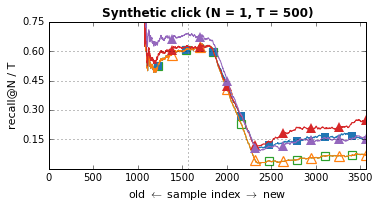

In [178]:
plot('Synthetic click', exp_click, click_staticMF, click_iMF, click_staticFMs, click_iFMs, click_sketch, N=1, T=500)
plt.yticks([.15, .30, .45, .60, .75])
plt.ylim([0.0, .75])

show_results(click_staticMF, click_iMF, click_staticFMs, click_iFMs, click_sketch)

## ML100k

In [179]:
## FMs
ML100k_staticFMs = read_result('results/recprofile/ML100k', 'ML100k', 'static-FMs', '3000', 5)
ML100k_iFMs = read_result('results/recprofile/ML100k', 'ML100k', 'iFMs', '3000', 5)

## MF
ML100k_staticMF = read_result('results/recprofile/ML100k', 'ML100k', 'static-MF', '3000', 5)
ML100k_iMF = read_result('results/recprofile/ML100k', 'ML100k', 'iMF', '3000', 5)

## Sketch
ML100k_sketch = read_result('results', 'ML100k', 'sketch', '3000', 1)

static MF
avg. reco time      = 0.00016
avg. update time    = ---
MPR   : mean (±std) = 49.68 (±0.320)
recall: mean (±std) = 0.021 (±0.004)

iMF
===
avg. reco time      = 0.00015
avg. update time    = 0.00003
MPR   : mean (±std) = 47.32 (±0.359)
recall: mean (±std) = 0.026 (±0.006)

static FMs
avg. reco time      = 0.02427
avg. update time    = ---
MPR   : mean (±std) = 36.07 (±0.127)
recall: mean (±std) = 0.023 (±0.008)

iFMs
====
avg. reco time      = 0.02449
avg. update time    = 0.00150
MPR   : mean (±std) = 32.55 (±0.023)
recall: mean (±std) = 0.035 (±0.008)

Sketch
avg. reco time      = 0.00665
avg. update time    = 0.00037
MPR   : mean (±std) = 47.86 (±0.000)
recall: mean (±std) = 0.032 (±0.008)



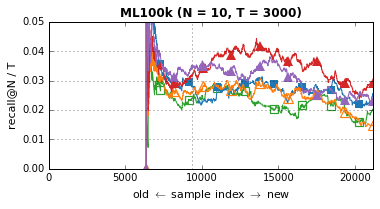

In [180]:
plot('ML100k', exp_ML100k, ML100k_staticMF, ML100k_iMF, ML100k_staticFMs, ML100k_iFMs, ML100k_sketch, N=10, T=3000)
plt.yticks([0.00, 0.01, 0.02, 0.03, 0.04, 0.05])
plt.ylim([0.0, 0.05])

show_results(ML100k_staticMF, ML100k_iMF, ML100k_staticFMs, ML100k_iFMs, ML100k_sketch)

## ML1M

In [199]:
## MF
ML1M_iMF = read_result('results/recprofile/ML1M', 'ML1M', 'iMF', '9000', 1)

## Sketch
ML1M_sketch = read_result('results', 'ML1M', 'sketch', '9000', 1)

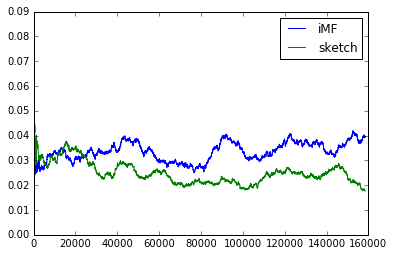

In [201]:
plt.plot(ML1M_iMF['recalls'][0], label='iMF')
plt.plot(ML1M_sketch['recalls'][0], label='sketch')

plt.legend()

## Experiments on different $\ell$

In [73]:
from converter.converter import Converter
from core.online_sketch import OnlineSketch

### ML100k

In [181]:
data = Converter().convert(dataset='ML100k')
batch_tail = data.n_batch_train + data.n_batch_test

In [182]:
p = np.sum(list(data.contexts.values()))
ell_bound = int(np.sqrt(p))
p, ell_bound

(73, 8)

In [184]:
d = {}

for ell in range(1, ell_bound + 1):
    print(ell)
    r = OnlineSketch(contexts=data.contexts, k=p, ell=ell, proj='Raw')
    
    r.set_can_repeat(data.can_repeat)
    r.fit(data.samples[:data.n_batch_train],
          data.samples[data.n_batch_train:batch_tail],
          at=10,
          n_epoch=1)
    
    res = r.evaluate(data.samples[batch_tail:],
                     window_size=3000,
                     at=10)
    
    d[ell] = res

1


[7735] epoch  1: recall@10 = 0.007075
[7735] epoch  1: recall@10 = 0.007075
[7735] [0.0, 0.00141509433962, 0.00283018867925, 0.00424528301887, 0.00424528301887, 0.00424528301887, 0.00518867924528, 0.00566037735849, 0.00660377358491, 0.00707547169811]
[7735] [0.0, 0.00141509433962, 0.00283018867925, 0.00424528301887, 0.00424528301887, 0.00424528301887, 0.00518867924528, 0.00566037735849, 0.00660377358491, 0.00707547169811]


2


[7735] epoch  1: recall@10 = 0.012264
[7735] epoch  1: recall@10 = 0.012264
[7735] [0.00188679245283, 0.00424528301887, 0.00518867924528, 0.00566037735849, 0.00566037735849, 0.00707547169811, 0.00707547169811, 0.00801886792453, 0.00990566037736, 0.0122641509434]
[7735] [0.00188679245283, 0.00424528301887, 0.00518867924528, 0.00566037735849, 0.00566037735849, 0.00707547169811, 0.00707547169811, 0.00801886792453, 0.00990566037736, 0.0122641509434]


3


[7735] epoch  1: recall@10 = 0.015094
[7735] epoch  1: recall@10 = 0.015094
[7735] [0.00471698113208, 0.0061320754717, 0.00896226415094, 0.00990566037736, 0.011320754717, 0.0117924528302, 0.0122641509434, 0.013679245283, 0.0141509433962, 0.0150943396226]
[7735] [0.00471698113208, 0.0061320754717, 0.00896226415094, 0.00990566037736, 0.011320754717, 0.0117924528302, 0.0122641509434, 0.013679245283, 0.0141509433962, 0.0150943396226]


4


[7735] epoch  1: recall@10 = 0.039151
[7735] epoch  1: recall@10 = 0.039151
[7735] [0.0117924528302, 0.0235849056604, 0.0311320754717, 0.0334905660377, 0.0339622641509, 0.0349056603774, 0.0353773584906, 0.0372641509434, 0.0372641509434, 0.0391509433962]
[7735] [0.0117924528302, 0.0235849056604, 0.0311320754717, 0.0334905660377, 0.0339622641509, 0.0349056603774, 0.0353773584906, 0.0372641509434, 0.0372641509434, 0.0391509433962]


5


[7735] epoch  1: recall@10 = 0.044811
[7735] epoch  1: recall@10 = 0.044811
[7735] [0.0122641509434, 0.0221698113208, 0.0330188679245, 0.036320754717, 0.0391509433962, 0.0419811320755, 0.0433962264151, 0.0443396226415, 0.0443396226415, 0.0448113207547]
[7735] [0.0122641509434, 0.0221698113208, 0.0330188679245, 0.036320754717, 0.0391509433962, 0.0419811320755, 0.0433962264151, 0.0443396226415, 0.0443396226415, 0.0448113207547]


6


[7735] epoch  1: recall@10 = 0.039151
[7735] epoch  1: recall@10 = 0.039151
[7735] [0.0127358490566, 0.025, 0.0301886792453, 0.0316037735849, 0.0334905660377, 0.0344339622642, 0.0358490566038, 0.0367924528302, 0.038679245283, 0.0391509433962]
[7735] [0.0127358490566, 0.025, 0.0301886792453, 0.0316037735849, 0.0334905660377, 0.0344339622642, 0.0358490566038, 0.0367924528302, 0.038679245283, 0.0391509433962]


7


[7735] epoch  1: recall@10 = 0.040566
[7735] epoch  1: recall@10 = 0.040566
[7735] [0.0150943396226, 0.0216981132075, 0.0292452830189, 0.0320754716981, 0.0330188679245, 0.0353773584906, 0.0377358490566, 0.0391509433962, 0.0396226415094, 0.0405660377358]
[7735] [0.0150943396226, 0.0216981132075, 0.0292452830189, 0.0320754716981, 0.0330188679245, 0.0353773584906, 0.0377358490566, 0.0391509433962, 0.0396226415094, 0.0405660377358]


8


[7735] epoch  1: recall@10 = 0.040094
[7735] epoch  1: recall@10 = 0.040094
[7735] [0.0160377358491, 0.025, 0.0311320754717, 0.0325471698113, 0.0353773584906, 0.036320754717, 0.0372641509434, 0.0382075471698, 0.038679245283, 0.0400943396226]
[7735] [0.0160377358491, 0.025, 0.0311320754717, 0.0325471698113, 0.0353773584906, 0.036320754717, 0.0372641509434, 0.0382075471698, 0.038679245283, 0.0400943396226]


In [185]:
mean_recalls, MPRs = [], []

for ell in range(1, ell_bound + 1):
    recalls, MPR, avg_recommend, avg_update = d[ell]
    mean_recalls.append(np.mean(recalls))
    MPRs.append(MPR)

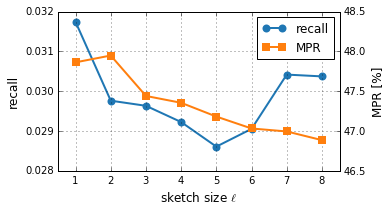

In [202]:
fig, ax1 = plt.subplots()

x = range(1, ell_bound + 1)
l1 = ax1.plot(x, mean_recalls, c=colors[0], label='recall', lw=2., ms=8., marker='o', mew=0.)
ax1.set_ylim(0.028, 0.032)
ax1.set_yticks([0.028, 0.029, 0.030, 0.031, 0.032])
ax1.set_ylabel('recall')

ax2 = ax1.twinx()
l2 = ax2.plot(x, MPRs, c=colors[2], label='MPR', lw=2., ms=8., marker='s', mew=0.)
ax2.set_ylim(46.5, 48.5)
ax2.set_yticks([46.5, 47.0, 47.5, 48.0, 48.5])
ax2.set_ylabel('MPR [%]')

lines = l1 + l2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=1)

ax1.set_xlabel(r'sketch size $\ell$')
ax1.grid()
ax1.set_xlim(0.5, 8.5)

fig.set_size_inches((5.5, 3))
fig.patch.set_alpha(0.0)

plt.tight_layout()

fig.savefig('../../paper/images/icmla-2016/ml100k_sketch_size.eps')

### Click

In [203]:
data = Converter().convert(dataset='click')
batch_tail = data.n_batch_train + data.n_batch_test

In [204]:
p = np.sum(list(data.contexts.values()))
ell_bound = int(np.sqrt(p))
p, ell_bound

(56, 7)

In [206]:
d_click = {}

for ell in range(1, ell_bound + 1):
    print(ell)
    r = OnlineSketch(contexts=data.contexts, k=p, ell=ell, proj='Raw')
    
    r.set_can_repeat(data.can_repeat)
    r.fit(data.samples[:data.n_batch_train],
          data.samples[data.n_batch_train:batch_tail],
          at=1,
          n_epoch=1)
    
    res = r.evaluate(data.samples[batch_tail:],
                     window_size=500,
                     at=1)
    
    d_click[ell] = res

1


[7735] epoch  1: recall@1 = 0.593838
[7735] epoch  1: recall@1 = 0.593838
[7735] [0.593837535014]
[7735] [0.593837535014]


2


[7735] epoch  1: recall@1 = 0.593838
[7735] epoch  1: recall@1 = 0.593838
[7735] [0.593837535014]
[7735] [0.593837535014]


3


[7735] epoch  1: recall@1 = 0.641457
[7735] epoch  1: recall@1 = 0.641457
[7735] [0.641456582633]
[7735] [0.641456582633]


4


[7735] epoch  1: recall@1 = 0.641457
[7735] epoch  1: recall@1 = 0.641457
[7735] [0.641456582633]
[7735] [0.641456582633]


5


[7735] epoch  1: recall@1 = 0.705882
[7735] epoch  1: recall@1 = 0.705882
[7735] [0.705882352941]
[7735] [0.705882352941]


6


[7735] epoch  1: recall@1 = 0.705882
[7735] epoch  1: recall@1 = 0.705882
[7735] [0.705882352941]
[7735] [0.705882352941]


7


[7735] epoch  1: recall@1 = 0.705882
[7735] epoch  1: recall@1 = 0.705882
[7735] [0.705882352941]
[7735] [0.705882352941]


In [207]:
mean_recalls, MPRs = [], []

for ell in range(1, ell_bound + 1):
    recalls, MPR, avg_recommend, avg_update = d_click[ell]
    mean_recalls.append(np.mean(recalls))
    MPRs.append(MPR)

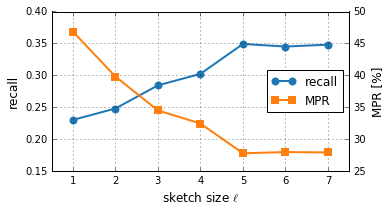

In [214]:
fig, ax1 = plt.subplots()

x = range(1, ell_bound + 1)
l1 = ax1.plot(x, mean_recalls, c=colors[0], label='recall', lw=2., ms=8., marker='o', mew=0.)
ax1.set_ylim(0.15, 0.4)
ax1.set_yticks([0.15, 0.2, 0.25, 0.30, 0.35, 0.40])
ax1.set_ylabel('recall')

ax2 = ax1.twinx()
l2 = ax2.plot(x, MPRs, c=colors[2], label='MPR', lw=2., ms=8., marker='s', mew=0.)
ax2.set_ylim(25, 50)
ax2.set_yticks([25, 30, 35, 40, 45, 50])
ax2.set_ylabel('MPR [%]')

lines = l1 + l2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=5)

ax1.set_xlabel(r'sketch size $\ell$')
ax1.grid()
ax1.set_xlim(0.5, 7.5)

fig.set_size_inches((5.5, 3))
fig.patch.set_alpha(0.0)

plt.tight_layout()

fig.savefig('../../paper/images/icmla-2016/click_sketch_size.eps')